In [1]:
import math

In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from sklearn import svm
from joblib import dump, load
from imblearn.over_sampling import RandomOverSampler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, matthews_corrcoef

In [3]:
RANDOM_STATE = 42

In [4]:
def one_hot_encode_sequences(df, column_name):
    # Define a mapping from amino acids to integers
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
    amino_acid_to_int = {aa: i for i, aa in enumerate(amino_acids)}
    num_amino_acids = len(amino_acids)

    encoded_sequences = []

    for sequence in df[column_name]:
        # Initialize a matrix of zeros
        encoded_matrix = np.zeros((len(sequence), num_amino_acids), dtype=int)

        for i, aa in enumerate(sequence):
            if aa in amino_acid_to_int:
                # Set the corresponding column to 1
                encoded_matrix[i, amino_acid_to_int[aa]] = 1
            else:
                raise ValueError(f"Invalid amino acid '{aa}' found in sequence.")

        encoded_sequences.append(encoded_matrix)

    return encoded_sequences

# GFP

In [5]:
df_GFP = pd.read_csv('gfp/gfp_data.csv')

In [6]:
df_GFP.head()

,Sequence,Description,Ligand,Data,Units,Assay/Protocol
0,MSEGEELFAGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,K1E+T7A+V53E+M231K,NaN,1.301,unitless,Brightness
1,MSEGEELFAGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,K1E+T7A+M76L+M231T,NaN,3.702,unitless,Brightness
2,MSEGEELFAGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,K1E+T7A+N133D,NaN,3.689,unitless,Brightness
3,MSEGEELFPGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTPKF...,K1E+T7P+L42P+Y180N+T184S+A204T,NaN,1.301,unitless,Brightness
4,MSEGEELFSGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,K1E+T7S+F98Y+K154R+E170G,NaN,3.647,unitless,Brightness


In [7]:
# GFP sequence and truncated version to match structure/dataset
wt = 'MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK'
wt_trunc = 'KGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK'


In [8]:
# Function to parse mutations and count
def count_mutations(df, wt_sequence):
    # Initialize a dictionary to count mutations
    mutation_count = {i: 0 for i in range(1, len(wt_sequence) + 1)}

    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        # Split the mutations by '+'
        mutations = row['Description'].split('+')

        # Iterate over each mutation
        for mutation in mutations:
            # Extract the position and compare with wildtype
            position = int(''.join(filter(str.isdigit, mutation)))
            wt_amino_acid = wt_sequence[position - 1]
            mut_amino_acid = mutation[-1]

            # Check if mutation is different from wildtype
            if wt_amino_acid != mut_amino_acid:
                mutation_count[position] += 1

    return mutation_count

# Count the mutations
mutation_counts = count_mutations(df_GFP, wt_trunc)

In [9]:
# Extract positions with zero mutations, we keep those fixed during design as we have no information on them
zero_mutation_positions = [position for position, count in mutation_counts.items() if count == 0]

# Print the positions with zero mutations
zero_mutation_positions



[117, 118, 236]

In [10]:
# one hot encode
df_GFP['encoded'] = one_hot_encode_sequences(df_GFP, 'Sequence')
# Flatten the encoded sequence
df_GFP['Flattened_Encoded'] = df_GFP['encoded'].apply(lambda x: x.flatten())
# Create a feature matrix X and target vector y
X = np.stack(df_GFP['Flattened_Encoded'].values)
y = df_GFP['Data'].values

In [11]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=RANDOM_STATE)

In [12]:
model = Ridge(alpha=1.0, solver='lsqr', tol=1e-4, max_iter=1000000)
model.fit(X_train, y_train)

Ridge(max_iter=1000000, solver='lsqr', tol=0.0001)

In [13]:
# Predict on the test set
y_pred = model.predict(X_test)
spearman_corr, p_value = spearmanr(y_pred, y_test)
print("Spearman Correlation:", spearman_corr)

Spearman Correlation: 0.7676198648740054


In [14]:
dump(model, 'gfp/gfp_ridge.joblib') # save model for later use (also provided as file in the repo)

['gfp/gfp_ridge.joblib']

# GB1

In [15]:
df_GB1 = pd.read_csv('gb1/gb1_mutations_full_data.csv')

/home/me/conda/envs/probs_design/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (8,10,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [16]:
df_GB1.head()

,Variants,HD,Count input,Count selected,Fitness,sequence,keep,one_vs_rest,one_vs_rest_validation,two_vs_rest,two_vs_rest_validation,three_vs_rest,three_vs_rest_validation,sampled,sampled_validation,low_vs_high,low_vs_high_validation
0,VDGV,0,92735,338346,1.000000,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYD...,True,train,NaN,train,NaN,train,NaN,train,NaN,test,NaN
1,ADGV,1,34,43,0.061910,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGADGEWTYD...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CDGV,1,850,641,0.242237,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGCDGEWTYD...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,DDGV,1,63,63,0.006472,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGDDGEWTYD...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,EDGV,1,841,190,0.032719,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGEDGEWTYD...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### here the keep variable is used to balance the dataset, as most mutations destroy fitness as seen in the boxplot below

<AxesSubplot:xlabel='Fitness'>

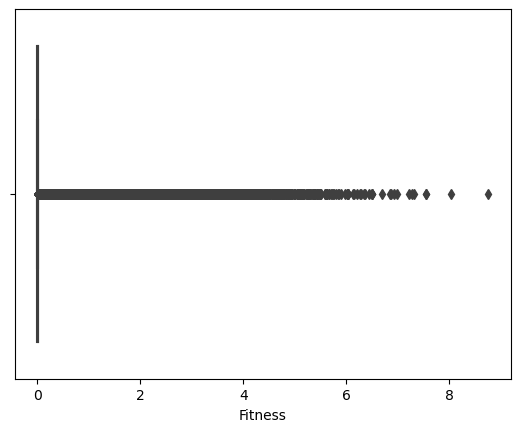

In [17]:
sns.boxplot(df_GB1.Fitness)

<AxesSubplot:xlabel='Fitness'>

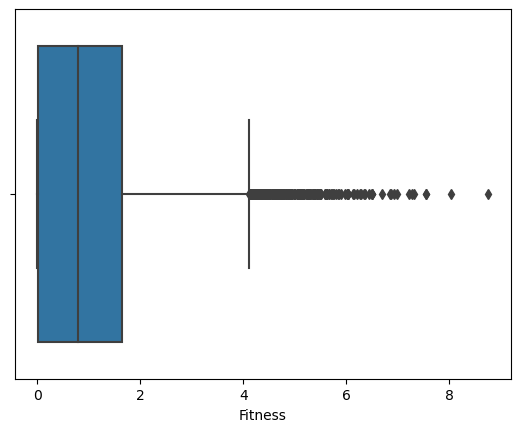

In [18]:
sns.boxplot(df_GB1[df_GB1.keep == True].Fitness)

In [19]:
print(len(df_GB1[df_GB1.keep == True]))
print(len(df_GB1))

8733
149361


In [20]:
df_GB1 = df_GB1[df_GB1.keep == True].copy()

In [21]:
df_GB1['trunc_seq'] = df_GB1['sequence'].apply(lambda seq: 'MTYKLIL'+seq[7:56]) # truncate it to the PDB sequence
df_GB1['encoded'] = one_hot_encode_sequences(df_GB1, 'trunc_seq')
df_GB1['Flattened_Encoded'] = df_GB1['encoded'].apply(lambda x: x.flatten())

In [22]:
# Create a feature matrix X and target vector y
X = np.stack(df_GB1['Flattened_Encoded'].values)
y = df_GB1['Fitness'].values

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=RANDOM_STATE)

In [24]:
model = Ridge(alpha=1.0, solver='lsqr', tol=1e-4, max_iter=1000000)
model.fit(X_train, y_train)

Ridge(max_iter=1000000, solver='lsqr', tol=0.0001)

In [25]:
y_pred = model.predict(X_test)

In [26]:
# Evaluate the model
spearman_corr, p_value = spearmanr(y_pred, y_test)
print("Spearman Correlation:", spearman_corr)
print("P-value:", p_value)

Spearman Correlation: 0.8098051820702165
P-value: 3.810811979116243e-204


In [27]:
dump(model, 'gb1/gb1_ridge.joblib') # save the model (already provided in github repo as well)

['gb1/gb1_ridge.joblib']

# Emi

In [28]:
df_emi = pd.read_csv('emi/emi_binding.csv')
df_emi.head()

,VH Sequence,ANT Binding,OVA Binding,pI_seq
0,QVQLVQSGAEVKKPGASVKVSCKASGYTFTDYYMHWVRQAPGQGLE...,0,1,8.64
1,QVQLVQSGAEVKKPGASVKVSCKASGYTFTDYYMHWVRQAPGQGLE...,1,1,8.96
2,QVQLVQSGAEVKKPGASVKVSCKASGYTFTDYFMHWVRQAPGQGLE...,0,1,7.96
3,QVQLVQSGAEVKKPGASVKVSCKASGYTFTDYSMHWVRQAPGQGLE...,1,1,8.60
4,QVQLVQSGAEVKKPGASVKVSCKASGYTFTDYFMHWVRQAPGQGLE...,0,1,7.96


In [29]:
df_emi['encoded'] = one_hot_encode_sequences(df_emi, 'VH Sequence')
df_emi['Flattened_Encoded'] = df_emi['encoded'].apply(lambda x: x.flatten())

In [30]:
wt = 'QVQLVQSGAEVKKPGASVKVSCKASGYTFTDYYMHWVRQAPGQGLEWMGRVNPNRRGTTYNQKFEGRVTMTTDTSTSTAYMELRSLRSDDTAVYYCARANWLDYWGQGTTVTVSS'

In [31]:
# Create a feature matrix X and target vector y
X = np.stack(df_emi['Flattened_Encoded'].values)
y = df_emi[['ANT Binding', 'OVA Binding']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=RANDOM_STATE)

In [32]:
lda_ANT = LinearDiscriminantAnalysis()
lda_ANT.fit(X_train, y_train[:,0])

LinearDiscriminantAnalysis()

In [33]:
y_pred = lda_ANT.predict(X_test)
accuracy = accuracy_score(y_test[:,0], y_pred)
mcc = matthews_corrcoef(y_test[:,0], y_pred)
print('accuracy:', accuracy, 'mcc:', mcc)

accuracy: 0.9375 mcc: 0.8732685075504191


In [34]:
lda_OVA = LinearDiscriminantAnalysis()
lda_OVA.fit(X_train, y_train[:,1])

LinearDiscriminantAnalysis()

In [35]:
y_pred = lda_OVA.predict(X_test)
accuracy = accuracy_score(y_test[:,1], y_pred)
mcc = matthews_corrcoef(y_test[:,1], y_pred)
print('accuracy:', accuracy, 'mcc:', mcc)

accuracy: 0.92 mcc: 0.8403386677035108


In [36]:
# save both models (provided in github repo as well)
dump(lda_OVA, 'emi/emi_LDA_OVA.joblib')
dump(lda_ANT, 'emi/emi_LDA_ANT.joblib')

['emi/emi_LDA_ANT.joblib']

# Herceptin

In [37]:
df_herceptin_neg = pd.read_csv('herceptin/mHER_H3_AgNeg.csv', index_col=0)
df_herceptin_pos = pd.read_csv('herceptin/mHER_H3_AgPos.csv', index_col=0)

In [38]:
df_herceptin = df_herceptin_neg.append(df_herceptin_pos).copy()

In [39]:
h_chain = 'EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLEWVARIYPTNGYTRYADSVKGRFTISADTSKNTAYLQMNSLRAEDTAVYYCSRWGGDGFYAMDYWGQGTLVTVS'
cdr3 = 'WGGDGFYAMD'

In [40]:
full_seq_list = []
for seq in df_herceptin.AASeq:
    full_seq_list.append(h_chain.replace(cdr3, seq))
df_herceptin['full_seq'] = full_seq_list

In [41]:
df_herceptin.head()

,Count,Fraction,NucSeq,AASeq,AgClass,full_seq
0,7,0.000007,TGTAGCAGGTACACTATCTGCAGTTTCTACAAGCTCCAGTATTGG,YTICSFYKLQ,0,EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLE...
1,95,0.000041,TGTAGCAGGTGGTTCCTCTGCGGCTTCTACCAGAACATGTATTGG,WFLCGFYQNM,0,EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLE...
2,3,0.000001,TGTAGCAGGTTCGGCAACATCAGCTCCTTCGCGATCGCGTATTGG,FGNISSFAIA,0,EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLE...
3,10,0.000005,TGTAGCAGGTTCAAGGTCAACGGTCTGTTCCCGCACCTCTATTGG,FKVNGLFPHL,0,EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLE...
4,16,0.000016,TGTAGCAGGTACACTATCTGCAGTATGTACGAGTTCGATTATTGG,YTICSMYEFD,0,EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLE...


In [42]:
df_herceptin['encoded'] = one_hot_encode_sequences(df_herceptin, 'full_seq')
df_herceptin['Flattened_Encoded'] = df_herceptin['encoded'].apply(lambda x: x.flatten())

In [43]:
# Create a feature matrix X and target vector y
X = np.stack(df_herceptin['Flattened_Encoded'].values)
y = df_herceptin['AgClass'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=RANDOM_STATE)

In [44]:
# we randomly oversample the training dataset to balance
ros = RandomOverSampler(random_state=RANDOM_STATE)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

In [45]:
lda_herceptin = LinearDiscriminantAnalysis()
lda_herceptin.fit(X_train_resampled, y_train_resampled)

LinearDiscriminantAnalysis()

In [46]:
y_pred = lda_herceptin.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
print('accuracy:', accuracy, 'mcc:', mcc)

accuracy: 0.7893923789907312 mcc: 0.5677487791517641


In [47]:
# save the model (file is provided in the github repo as well)
dump(lda_herceptin, 'herceptin/lda_herceptin.joblib')

['herceptin/lda_herceptin.joblib']